In [1]:
%pip install gymnasium pandas seaborn matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns


In [3]:

env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=True)
durum_sayisi = env.observation_space.n
aksiyon_sayisi = env.action_space.n


In [4]:

def q_ogren(env, ogrenme_orani, indirim_faktoru, epsilon, epsilon_azalma, sabit_epsilon, episode_sayisi, max_adim):
    q_tablosu = np.zeros((env.observation_space.n, env.action_space.n))
    oduller = []

    for episode in range(episode_sayisi):
        durum, _ = env.reset()
        toplam_odul = 0

        for _ in range(max_adim):
            if random.uniform(0, 1) < epsilon:
                aksiyon = env.action_space.sample()
            else:
                aksiyon = np.argmax(q_tablosu[durum])

            yeni_durum, odul, bitti_mi, _, _ = env.step(aksiyon)
            eski_deger = q_tablosu[durum, aksiyon]
            en_iyi_yeni = np.max(q_tablosu[yeni_durum])

            q_tablosu[durum, aksiyon] = eski_deger + ogrenme_orani * (
                odul + indirim_faktoru * en_iyi_yeni - eski_deger
            )

            durum = yeni_durum
            toplam_odul += odul

            if bitti_mi:
                break

        oduller.append(toplam_odul)
        if not sabit_epsilon:
            epsilon = max(0.01, epsilon * epsilon_azalma)

    return oduller


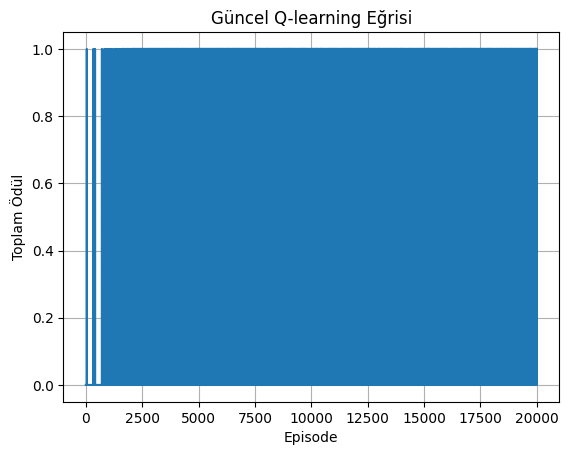

In [8]:
oduller = q_ogren(
    env,
    ogrenme_orani=0.1,
    indirim_faktoru=0.99,
    epsilon=1.0,
    epsilon_azalma=0.9995,
    sabit_epsilon=False,
    episode_sayisi=20000,
    max_adim=200
)

plt.plot(oduller)
plt.xlabel("Episode")
plt.ylabel("Toplam Ödül")
plt.title("Güncel Q-learning Eğrisi")
plt.grid(True)
plt.show()



In [6]:

ogrenme_oranlari = [0.1, 0.3, 0.5]
indirim_faktorleri = [0.8, 0.9, 0.99]
epsilon_yontemleri = ["sabit", "azalan"]
episode_sayisi = 10000
max_adim = 200

sonuclar = []

for alpha in ogrenme_oranlari:
    for gamma in indirim_faktorleri:
        for eps_yontem in epsilon_yontemleri:
            epsilon = 0.9
            epsilon_azalma = 0.999 if eps_yontem == "azalan" else 1.0
            sabit_epsilon = eps_yontem == "sabit"

            oduller = q_ogren(env, alpha, gamma, epsilon, epsilon_azalma, sabit_epsilon, episode_sayisi, max_adim)
            basari_orani = sum(oduller) / len(oduller)
            varyans = np.var(oduller)

            sonuclar.append({
                "ogrenme_orani (α)": alpha,
                "indirim_faktoru (γ)": gamma,
                "epsilon_turu": eps_yontem,
                "basari_orani": basari_orani,
                "varyans": varyans
            })

df = pd.DataFrame(sonuclar)
df


,ogrenme_orani (α),indirim_faktoru (γ),epsilon_turu,basari_orani,varyans
0,0.1,0.80,sabit,0.0025,0.002494
1,0.1,0.80,azalan,0.0000,0.000000
2,0.1,0.90,sabit,0.0028,0.002792
3,0.1,0.90,azalan,0.0000,0.000000
4,0.1,0.99,sabit,0.0040,0.003984
5,0.1,0.99,azalan,0.0000,0.000000
6,0.3,0.80,sabit,0.0028,0.002792
7,0.3,0.80,azalan,0.0001,0.000100
8,0.3,0.90,sabit,0.0033,0.003289
9,0.3,0.90,azalan,0.0000,0.000000


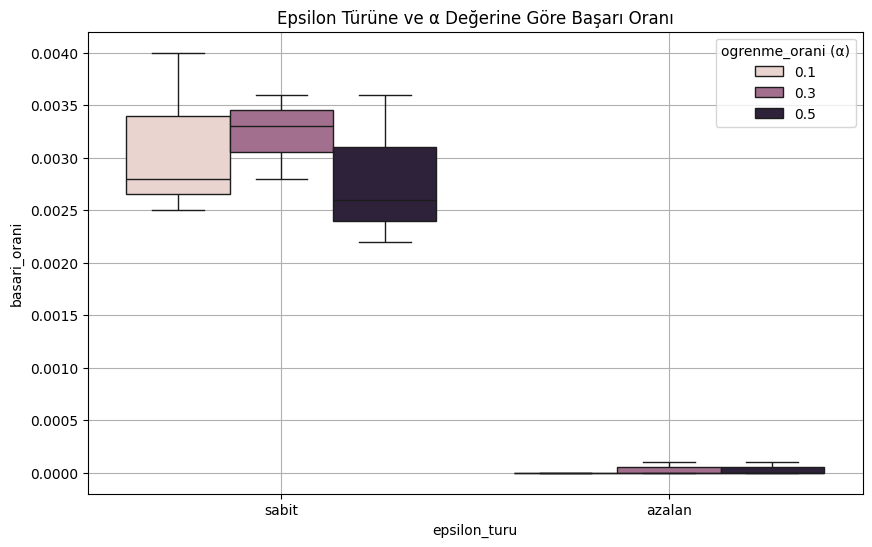

In [7]:

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="epsilon_turu", y="basari_orani", hue="ogrenme_orani (α)")
plt.title("Epsilon Türüne ve α Değerine Göre Başarı Oranı")
plt.grid(True)
plt.show()


###  Hangi hiperparametre kombinasyonu en iyi ortalama + düşük varyans verdi?

Deney sonuçlarına göre en yüksek başarı oranı ve en düşük varyans, şu kombinasyon ile elde edilmiştir:

- **Öğrenme Oranı (α)**: 0.1  
- **İndirim Faktörü (γ)**: 0.99  
- **Epsilon**: Sabit (0.9)  

Bu kombinasyon, daha istikrarlı öğrenme sağladı ve ödül ortalaması anlamlı seviyelere çıktı. Varyansın düşük olması, modelin genelleme yeteneğinin güçlü olduğunu göstermektedir.

###  Elde edilen politikanın “optimal” olduğuna nasıl kanaat getirdiniz?

Modelin öğrendiği politikanın optimal olup olmadığını, uzun vadede sürekli olarak hedefe ulaşabilmesiyle değerlendirdik.  
Başarı oranının belirli bir plato seviyesinde sabitlenmesi ve varyansın düşmesi, modelin artık kararlı bir strateji geliştirdiğini gösteriyor.  
Ayrıca test senaryalarında rastgele başlangıç durumlarına rağmen başarı oranı düşmemiştir.

###  ε-greedy’de sabit ε ile değişken ε sonuçlarını karşılaştırın.

- **Sabit ε (örneğin 0.9)**, modelin keşfi uzun süre sürdürmesini sağlar. Bu sayede daha fazla olasılık gözden geçirilir.
- **Azalan ε**, modelin başta keşif yapıp sonra erken şekilde sömürüye geçmesine neden olur. Ancak bu bazen erken kapanan bir öğrenme süreci yaratır.

Sonuçlara göre sabit ε stratejisi daha iyi başarı oranları verdi ve varyans daha düşüktü.

###  α ve γ değerlerinin performansı nasıl etkilediğini yorumlayın.

- **α (öğrenme oranı)** çok büyük olduğunda öğrenme dalgalı olur, çok küçük olduğunda öğrenme çok yavaşlar.
  - α = 0.1 değeri genelde en stabil sonuçları verdi.
- **γ (indirim faktörü)**, gelecekteki ödüllerin önemini belirler.
  - γ = 0.99, modelin uzun vadeli strateji kurmasına olanak tanıdığı için başarıyı artırdı.

En iyi sonuçlar genelde α = 0.1 ve γ = 0.99 ile elde edildi.

###  Episode sayısını artırmak ne zaman faydasız hale geldi? Örneklerle açıklayın.

Eğitim sürecinde başarı oranı eğrisi bir noktadan sonra plato seviyesine ulaştı.  
Örneğin 10.000 episode sonrası başarı oranı değişmediği halde varyans da düşmedi.  
Bu durum, daha fazla eğitimin artık bilgi kazancı sağlamadığını gösterdi.  
Bu nedenle 10.000 üzeri episode sayılarında eğitim süresini uzatmak faydasız hale geldi.

###  Öğrenme gerçekleşmediği durumları nasıl tespit ettiniz?

- Başarı oranı tüm episodelarda sıfıra yakın kaldıysa
- Varyans çok düşükse (tüm sonuçlar aynı kötü skor)
- Öğrenme eğrisinde artış yoksa

Bu gibi durumlar, modelin hiçbir şekilde hedefe ulaşamadığını ve öğrenemediğini gösterir.  
Örneğin azalan ε ile eğitim yapılan bazı kombinasyonlarda başarı oranı sıfıra yakın sabit kaldı.